In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import chemotax3, chemotax3_squish, chemotax3_squish_ss, chemotax3_ss
from scipy.optimize import curve_fit
import pandas as pd

def lobf(x, m, b):
    return m * x + b

def pobf(x, a, n):
    return a * x**n

def load_cond(n_grps, apply_grad, finite_domain, tf, grp_size, xb, p0, h, g, x_init, data_dir):
    '''
    Loads groups of ave position and averages.
    '''
    this_cond = []
    for i in range(n_grps):
        fn = f"chemotax_mean_pos_gradient_{apply_grad}_finite_{finite_domain}_tf_{tf}_n_runs_{grp_size}_xb_{xb}_p0_{p0}_h_{h}_g_{g}_x_init_{x_init}_seed_{i}.csv"
        this_grp = np.loadtxt(data_dir + fn, delimiter=',')
        this_cond.append(this_grp)

    this_cond = np.vstack(this_cond)
    this_cond_mean = this_cond.mean(axis=0)
    this_cond_sem = this_cond.std(axis=0) / np.sqrt(n_grps)
    return this_cond_mean, this_cond_sem, this_cond

def fit_log_lines(x, y_mat, f=lobf, n_grps=4):
    '''
    Fit lines in log-log space for each group of data.
    Return average parameters with sem.
    y_mat: (n_points x n_groups) matrix of dependent variable
    '''
    exps = []
    prefs = []
    for i in range(n_grps):
        popt, _ = curve_fit(f, np.log(x), np.log(y_mat[:,i]))
        exps.append(popt[0])
        prefs.append(np.exp(popt[1]))

    popt, _ = curve_fit(f, np.log(x), np.log(y_mat.mean(axis=1)))
    mean_pref, mean_exp = np.exp(popt[1]), popt[0]
    exps = np.array(exps)
    prefs = np.array(prefs)
    exp_sem = exps.std() / np.sqrt(n_grps)
    pref_sem = prefs.std() / np.sqrt(n_grps)
    pref, exp = (mean_pref, pref_sem), (mean_exp, exp_sem)
    return pref, exp

def fit_curves(f, x, y_mat, n_grps=4):
    '''
    Fit curves for each group of data.
    Return average parameters with sem.
    y_mat: (n_points x n_groups) matrix of dependent variable
    '''
    params = []
    for i in range(n_grps):
        popt, _ = curve_fit(f, x, y_mat[:,i])
        params.append(popt)

    params = np.array(params)
    mean_params, _ = curve_fit(f, x, y_mat.mean(axis=1))
    params_sem = params.std(axis=0) / np.sqrt(n_grps)
    return mean_params, params_sem

def crossover(x, a, b):
    return (a * x) / (1 + (x / (b))**0.5)

# Quick sim and average

In [2]:
g = 0.025
h = 0.7
p0 = 0.1
finite_domain = True
apply_grad = True
n_runs = int(1e4)
tf = int(1e4)
x_init = 10
xb = 150

runs = chemotax3_squish(p0=p0, h=h, g=g, finite_domain=finite_domain, apply_grad=apply_grad, n_runs=n_runs, tf=tf, x_init=x_init, xb=xb)

In [60]:
runs

array([[10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20.]])

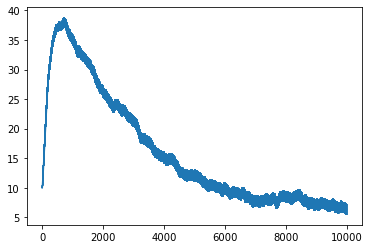

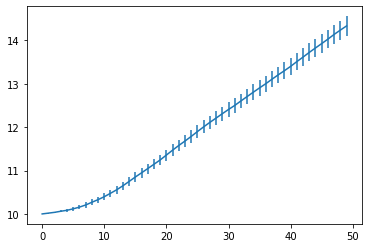

In [3]:
mean_pos = runs.mean(axis=0)
sem_pos = runs.std(axis=0) / np.sqrt(n_runs)
t = np.arange(tf)

plt.errorbar(t, mean_pos, yerr=sem_pos)
plt.show()

tstop = 50

plt.errorbar(t[:tstop], mean_pos[:tstop], yerr=sem_pos[:tstop])
plt.show()


 # No gradient

# Unbounded system

Load in sim data

In [25]:
p0 = 0.15
h = 0.7
g = 0.015
x_init = 10
xb = None
tf = 50000
apply_grad = True
finite_domain = False
total_runs = 1e4
grp_size = 2500
n_grps = int(total_runs / grp_size)
data_dir = '/home/stef/MarkoRotation/data/'

ub_mean, ub_sem, ub = load_cond(n_grps, apply_grad, finite_domain, tf, grp_size, xb, p0, h, g, x_init, data_dir)

In [35]:
50 / 0.06, 250 + 339

(833.3333333333334, 589)

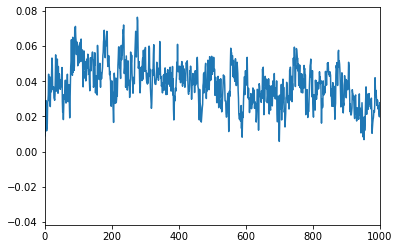

In [29]:
t = np.arange(tf)
v = ub_mean[1:] - ub_mean[:-1]
plt.plot(t[:-1], v)
# plt.yscale('log')
# plt.xscale('log')
plt.xlim(0,1000)
plt.show()

plt.plot(ub_mean)

[1.29051434e-01 3.38165207e+02]
[1.99646772e-02 1.20083201e+02]


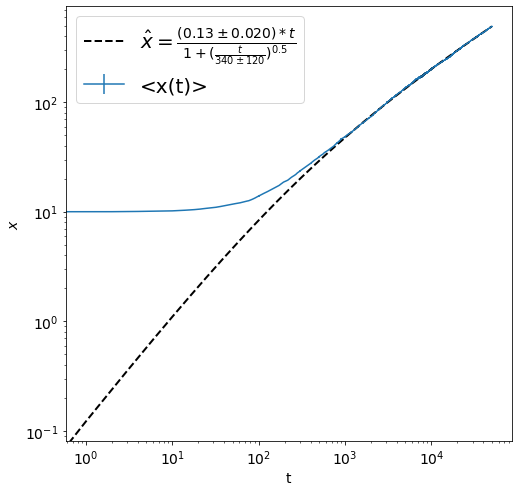

In [37]:
tstart = 0
t = np.arange(tstart, tf)
mean_params, params_sem = fit_curves(crossover, t, ub[:,tstart:].T)
print(mean_params)
print(params_sem)

ub_mean_hat = crossover(t, *mean_params) # Prediction

# Downsample errorbars for plot
ds = 100
plt_err = np.zeros_like(ub_sem)
plt_err[::ds] = ub_sem[::ds]

# Plot on log-log
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar(t, ub_mean[tstart:], yerr=plt_err[tstart:], label=r'<x(t)>')
ax.plot(t, ub_mean_hat, 'k--', lw=2, label=r'$\hat{x}=\frac{(0.13 \pm 0.020) * t}{1 + (\frac{t}{340 \pm 120})^{0.5} }$')

# Style
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel(r'$x$', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=20)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.show()

# Bounded system

Parameter settings

In [18]:
p0 = 0.15
h = 0.7
g = 0.015
x_init = 10
xbs = np.arange(50, 110, 10)
apply_grad = True
finite_domain = True
total_runs = 1e4
grp_size = 2500
n_grps = int(total_runs / grp_size)
data_dir = '/home/stef/MarkoRotation/data/'

### Example at xb = 100

Load in sim data

In [19]:
xb = 100
tf = (2 * xb)**2 + 1000
xb100_mean, xb100_sem, xb100 = load_cond(n_grps, apply_grad, finite_domain, tf, grp_size, xb, p0, h, g, x_init, data_dir)

Plot example trace

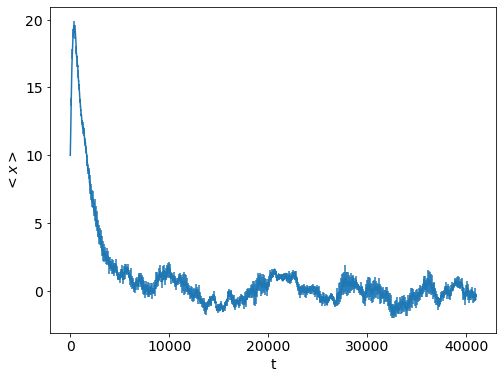

In [23]:
# Downsample errorbars for plot
ds = 100
plt_err = np.zeros_like(xb100_sem)
plt_err[::ds] = xb100_sem[::ds]

t = np.arange(tf)

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(t, xb100_mean, yerr=plt_err)

# Style
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('t', fontsize=14)
ax.set_ylabel(r'$<x>$', fontsize=14)
plt.show()

Run xb=100, keep all traces

Get final position distribution

### Return characteristics
Load in sim data

In [43]:
xbs = np.arange(150, 220, 10)
xmaxes = []
tcs = [] # Characteristic times
return_curves = []
tmaxes = []
# Iterate over boundary positions ("conds")
for xb in xbs:
    tf = (2 * xb)**2 + 1000
    this_mean, this_sem, this_cond = load_cond(n_grps, apply_grad, finite_domain, tf, grp_size, xb, p0, h, g, x_init, data_dir) # Load in
    this_xmaxes = this_cond.max(axis=1)
    this_tmaxes = this_cond.argmax(axis=1)

    this_tcs = []
    this_return_curves = []
    # Iterate over groups
    for i, tmax in enumerate(this_tmaxes):
        this_return_curves.append(this_cond[i,tmax:])
        this_tcs.append(np.where(this_cond[i, tmax:] <= this_xmaxes[i] / np.e)[0][1])

    xmaxes.append(this_xmaxes)
    tcs.append(this_tcs)
    return_curves.append(this_return_curves)
    tmaxes.append(this_tmaxes)

xmaxes = np.array(xmaxes)
tcs = np.array(tcs)
tmaxes = np.array(tmaxes)

min_return_t = 1e10
for elt in return_curves:
    for sub_elt in elt:
        if sub_elt.shape[0] < min_return_t:
            min_return_t = sub_elt.shape[0]

return_curves_new = []
for elt in return_curves:
    this_arr = np.vstack([sub_elt[:min_return_t] for sub_elt in elt])
    this_mean, this_sem = this_arr.mean(axis=0), this_arr.std(axis=0) / np.sqrt(n_grps)
    return_curves_new.append(np.vstack([this_mean, this_sem]))

return_curves = return_curves_new

#### xmax vs xb

2.087484765014772 0.02455828859805536
0.24758265226509765 0.37796964923699594


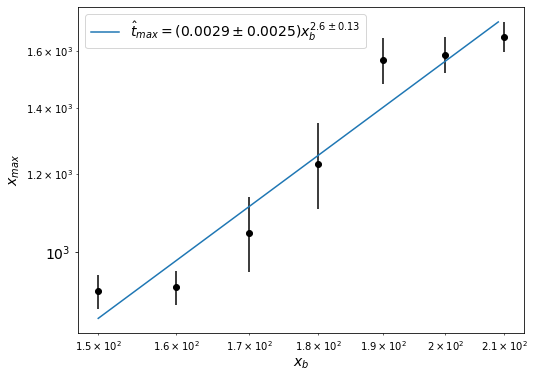

In [44]:
pref, exp = fit_log_lines(xbs, tmaxes)
mean_pref, pref_sem = pref
mean_exp, exp_sem = exp

data_mean, data_sem = tmaxes.mean(axis=1), tmaxes.std(axis=1) / np.sqrt(n_grps)
x = np.arange(xbs[0], xbs[-1])

print(mean_exp, mean_pref)
print(exp_sem, pref_sem)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(xbs, data_mean, yerr=data_sem, fmt='ko')
ax.plot(x, pobf(x, mean_pref, mean_exp), label=r'$\hat{t}_{max}=(0.0029 \pm 0.0025)x_{b}^{2.6 \pm 0.13}$')

# Style
ax.set_yscale('log')
ax.set_xscale('log')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel(r'$x_{b}$', fontsize=14)
ax.set_ylabel(r'$x_{max}$', fontsize=14)
ax.legend(fontsize=14)
plt.show()

#### tc vs xb

1.9134707706571412 0.29613114381957645
0.3086561451356551 5.362160174534582


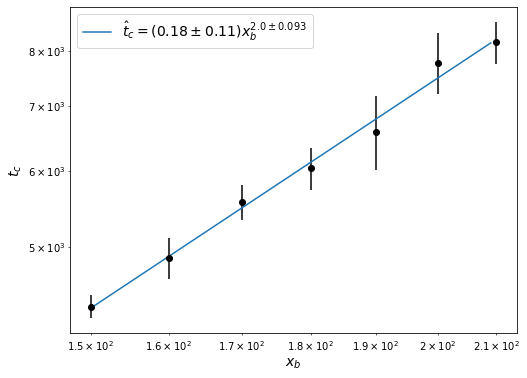

In [45]:
pref, exp = fit_log_lines(xbs, tcs)
mean_pref, pref_sem = pref
mean_exp, exp_sem = exp
data_mean, data_sem = tcs.mean(axis=1), tcs.std(axis=1) / np.sqrt(n_grps)
x = np.arange(xbs[0], xbs[-1])

print(mean_exp, mean_pref)
print(exp_sem, pref_sem)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(xbs, data_mean, yerr=data_sem, fmt='ko')
ax.plot(x, pobf(x, mean_pref, mean_exp), label=r'$\hat{t}_{c}=(0.18 \pm 0.11)x_{b}^{2.0 \pm 0.093}$')

# Style
ax.set_yscale('log')
ax.set_xscale('log')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel(r'$x_{b}$', fontsize=14)
ax.set_ylabel(r'$t_{c}$', fontsize=14)
ax.legend(fontsize=14)
plt.show()

#### x vs t - t_max

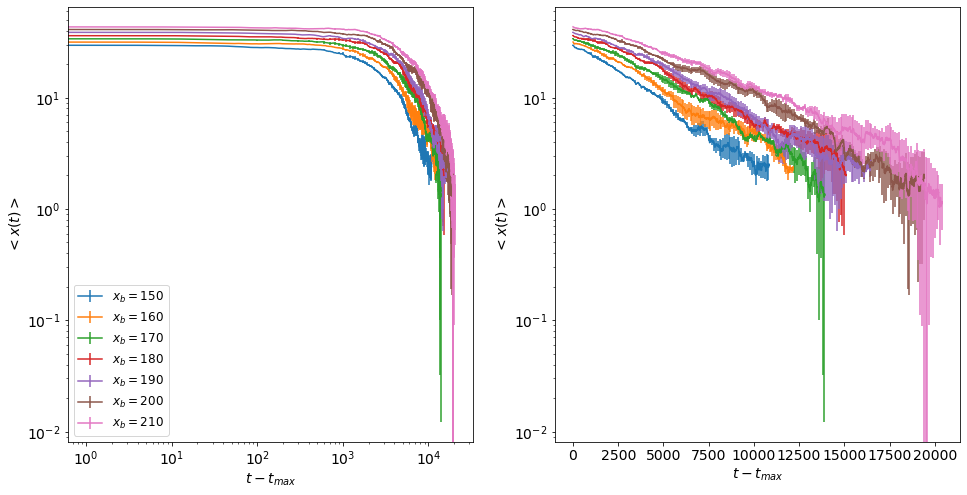

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))
mean_tcs = tcs.mean(axis=1)
t_stop = (mean_tcs * 2.5).astype(int)
ds = 100

for i, elt in enumerate(return_curves):
    plt_err = np.zeros(shape=(min_return_t,))
    plt_err[::ds] = elt[1][::ds]
    t = np.arange(t_stop[i])
    ax[0].errorbar(t, y=elt[0, :t_stop[i]], yerr=plt_err[:t_stop[i]], label=r'$x_{b}=$' + f"{xbs[i]}")
    ax[1].errorbar(t, y=elt[0, :t_stop[i]], yerr=plt_err[:t_stop[i]])

# Style
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_yscale('log')
ax[0].xaxis.set_tick_params(labelsize=14)
ax[0].yaxis.set_tick_params(labelsize=14)
ax[1].xaxis.set_tick_params(labelsize=14)
ax[1].yaxis.set_tick_params(labelsize=14)
ax[0].set_xlabel(r'$t - t_{max}$', fontsize=14)
ax[0].set_ylabel(r'$<x(t)>$', fontsize=14)
ax[1].set_xlabel(r'$t - t_{max}$', fontsize=14)
ax[1].set_ylabel(r'$<x(t)>$', fontsize=14)
ax[0].legend(fontsize=12)
plt.show()

# Squishy boundary

In [9]:
g = 0.025
h = 0.7
p0 = 0.1
finite_domain = True
apply_grad = True
n_runs = int(1e4)
x_init = 10
xbs = np.arange(50, 150, 10)

reflect_xfs = []
squishy_xfs = []
for xb in xbs:
    tf = int((2 * xb)**2 + 5000)
    this_squish = chemotax3_squish_ss(p0=p0, h=h, g=g, finite_domain=finite_domain, apply_grad=apply_grad, n_runs=n_runs, tf=tf, x_init=x_init, xb=xb)
    this_reflect = chemotax3_ss(p0=p0, h=h, g=g, finite_domain=finite_domain, apply_grad=apply_grad, n_runs=n_runs, tf=tf, x_init=x_init, xb=xb)
    squishy_xfs.append([this_squish.mean(), this_squish.std() / np.sqrt(n_runs)])
    reflect_xfs.append([this_reflect.mean(), this_reflect.std() / np.sqrt(n_runs)])

reflect_xfs, squishy_xfs = np.array(reflect_xfs), np.array(squishy_xfs)

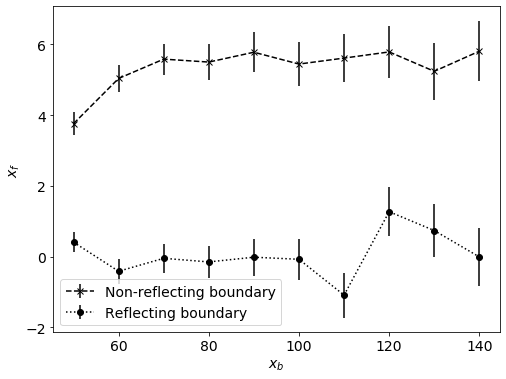

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(xbs, squishy_xfs[:,0], yerr=squishy_xfs[:,1], fmt='kx--', label="Non-reflecting boundary")
ax.errorbar(xbs, reflect_xfs[:,0], yerr=reflect_xfs[:,1], fmt='ko:', label="Reflecting boundary")

# Style
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel(r'$x_{b}$', fontsize=14)
ax.set_ylabel(r'$x_{f}$', fontsize=14)
ax.legend(fontsize=14)
plt.show()

# Calculate chemotactic coefficient

In [4]:
# Calculate chemotactic coeff and error bars using grouping

h = 0.7
n_runs = 10000
tmax = 1000
finite_domain = False
apply_grad = True
x_init = 0
xmax = None
seed = 1234
grp_size = 2500
n_grps = int(n_runs / grp_size)
xstep = 1
tstep = 1
gs = [0.005, 0.01, 0.015, 0.02, 0.025]
gs = np.array(gs)
p0s = [0.1, 0.15, 0.2]
tstart = 0
tstop = 50 # Fit line from tstart to tstop
data_dir = '/home/stef/MarkoRotation/data/'

mean_vels = []
mean_kappas = []
for p0 in p0s:
    vels = []
    for i in range(n_grps):
        this_vels = []
        for g in gs:
            # Load in
            fn = f"chemotax2_gradient_{apply_grad}_finite_{finite_domain}_tmax_{tmax}_n_runs_{n_runs}_xmax_{xmax}_p0_{p0}_h_{h}_g_{g}_x_init_{x_init}_seed_{seed}.csv"
            runs = np.loadtxt(data_dir + fn, delimiter=',')

            # Slice ith group
            # Calculate mean pos
            this_ave_pos = runs[i*grp_size:(i+1)*grp_size].mean(axis=0)

            # Calculate ave velocity
            popt, pcov = curve_fit(slope_only, np.arange(tstart, tstop), this_ave_pos[tstart:tstop])
            this_vels.append(popt[0])
            
        vels.append(this_vels)

    vels = np.array(vels)
    mean_vels.append([vels.mean(axis=0), vels.std(axis=0) / np.sqrt(n_grps)])

    # Calculate chemotactic coeff
    gamma = h * gs
    kappas = vels / gamma.reshape(1,-1)
    mean_kappas.append([kappas.mean(axis=0), kappas.std(axis=0) / np.sqrt(n_grps)])

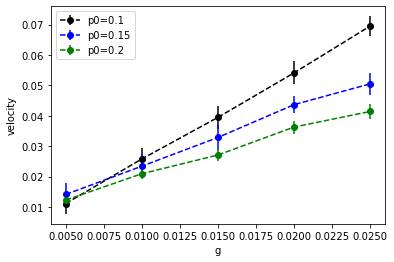

In [5]:
colors = ['k', 'b', 'g']
fig, ax = plt.subplots()
for i, p0 in enumerate(p0s):
    ax.errorbar(gs, mean_vels[i][0], yerr=mean_vels[i][1], label=f"p0={p0}", color=colors[i], fmt='--o')
ax.set_xlabel('g')
ax.set_ylabel('velocity')
ax.legend()
plt.show()

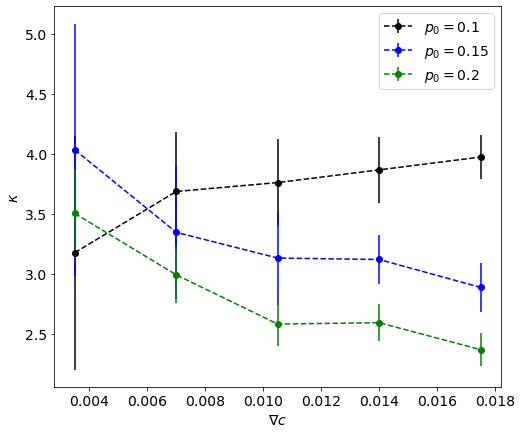

In [11]:
# Calculate chemotactic coeff

colors = ['k', 'b', 'g']
fig, ax = plt.subplots(figsize=(8,7))
for i, p0 in enumerate(p0s):
    gamma = h * gs
    ax.errorbar(gamma, mean_kappas[i][0], yerr=mean_kappas[i][1], color=colors[i], fmt='o--', label=r'$p_0=$' + f"{p0}")

ax.set_xlabel(r'$\nabla c$', fontsize=14)
ax.set_ylabel(r'$\kappa$', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(fontsize=14)
plt.show()

In [7]:
5 / 2

2.5